<a href="https://colab.research.google.com/github/MatthewSebastian15/datacomp/blob/main/DataComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from IPython.display import display

# Load Dataset

In [2]:
url = "https://raw.githubusercontent.com/MatthewSebastian15/datacomp/main/public-transport.csv"
df = pd.read_csv(url)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37900 entries, 0 to 37899
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transID           37900 non-null  object 
 1   payCardID         37900 non-null  int64  
 2   payCardBank       37900 non-null  object 
 3   payCardName       37900 non-null  object 
 4   payCardSex        37900 non-null  object 
 5   payCardBirthDate  37900 non-null  int64  
 6   corridorID        36643 non-null  object 
 7   corridorName      35970 non-null  object 
 8   direction         37900 non-null  float64
 9   tapInStops        36687 non-null  object 
 10  tapInStopsName    37900 non-null  object 
 11  tapInStopsLat     37900 non-null  float64
 12  tapInStopsLon     37900 non-null  float64
 13  stopStartSeq      37900 non-null  int64  
 14  tapInTime         37900 non-null  object 
 15  tapOutStops       35611 non-null  object 
 16  tapOutStopsName   36556 non-null  object

In [4]:
df.describe()

payCardID  payCardBirthDate     direction  tapInStopsLat  \
count  3.790000e+04      37900.000000  37900.000000   37900.000000   
mean   4.250060e+17       1990.089314      0.500633      -6.214838   
std    1.321699e+18         13.051482      0.500006       0.057911   
min    6.040368e+10       1946.000000      0.000000      -6.394973   
25%    1.800442e+14       1982.000000      0.000000      -6.245863   
50%    3.507947e+15       1990.000000      1.000000      -6.214587   
75%    4.699023e+15       2001.000000      1.000000      -6.175528   
max    4.997694e+18       2012.000000      1.000000      -6.089429   

       tapInStopsLon  stopStartSeq  tapOutStopsLat  tapOutStopsLon  \
count   37900.000000  37900.000000    36556.000000    36556.000000   
mean      106.841554     13.572480       -6.214651      106.841233   
std         0.060369     12.237623        0.059022        0.060999   
min       106.614730      0.000000       -6.394973      106.614730   
25%       106.803470      4.000000       -6.247225      106.801750   
50%       106.834830     10.000000       -6.214718      106.834580   
75%       106.882270     19.000000       -6.174736      106.883030   
max       107.023950     68.000000       -6.091746      107.023660   

         stopEndSeq     payAmount  
count  36556.000000  36893.000000  
mean      21.219909   2699.712683  
std       13.800689   4212.225592  
min        1.000000      0.000000  
25%       11.000000      0.000000  
50%       18.000000   3500.000000  
75%       29.000000   3500.000000  
max       77.000000  20000.000000

In [5]:
df.isnull().sum()

transID                0
payCardID              0
payCardBank            0
payCardName            0
payCardSex             0
payCardBirthDate       0
corridorID          1257
corridorName        1930
direction              0
tapInStops          1213
tapInStopsName         0
tapInStopsLat          0
tapInStopsLon          0
stopStartSeq           0
tapInTime              0
tapOutStops         2289
tapOutStopsName     1344
tapOutStopsLat      1344
tapOutStopsLon      1344
stopEndSeq          1344
tapOutTime          1344
payAmount           1007
dtype: int64

# Data Cleaning & Preprocessing

## CorridorID & CorridorName

In [6]:
corridor_map_id_to_name = df[['corridorID','corridorName']].dropna().drop_duplicates().set_index('corridorID')['corridorName'].to_dict()
corridor_map_name_to_id = {v:k for k,v in corridor_map_id_to_name.items()}
df['corridorName'] = df['corridorName'].fillna(df['corridorID'].map(corridor_map_id_to_name))
df['corridorID'] = df['corridorID'].fillna(df['corridorName'].map(corridor_map_name_to_id))
df = df.dropna(subset=['corridorID','corridorName'])

## Mapping Stops

In [7]:
stop_map_in = df[['tapInStops','tapInStopsName']].dropna().drop_duplicates().set_index('tapInStopsName')['tapInStops'].to_dict()
df['tapInStops'] = df['tapInStops'].fillna(df['tapInStopsName'].map(stop_map_in))
df = df.dropna(subset=['tapInStops'])

In [8]:
stop_map_out = df[['tapOutStops','tapOutStopsName']].dropna().drop_duplicates().set_index('tapOutStopsName')['tapOutStops'].to_dict()
df['tapOutStops'] = df['tapOutStops'].fillna(df['tapOutStopsName'].map(stop_map_out))
df['tapOutStops'] = df['tapOutStops'].fillna('Unknown')

## payAmount & fare_category

In [9]:
corridor_fare_map = df.groupby('corridorID')['payAmount'].median()
df['payAmount'] = df['payAmount'].fillna(df['corridorID'].map(corridor_fare_map))
df['payAmount'] = df['payAmount'].fillna(df['payAmount'].median())
df['payAmount'] = df['payAmount'].clip(lower=0)

df['fare_category'] = pd.cut(df['payAmount'], bins=[-1, 0, 3500, float('inf')],labels=['Free', 'Normal', 'Premium'])

## Convert Datetime

In [10]:
df['tapInTime'] = pd.to_datetime(df['tapInTime'], errors='coerce')
df['tapOutTime'] = pd.to_datetime(df['tapOutTime'], errors='coerce')

df['duration_minutes'] = (df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60
df = df[(df['duration_minutes'] > 0.5) & (df['duration_minutes'] < 240)]

In [11]:
df[['tapInTime','tapOutTime','duration_minutes']].head(15)

tapInTime          tapOutTime  duration_minutes
0  2023-04-03 05:21:44 2023-04-03 06:00:53         39.150000
1  2023-04-03 05:42:44 2023-04-03 06:40:01         57.283333
2  2023-04-03 05:59:06 2023-04-03 06:50:55         51.816667
3  2023-04-03 05:44:51 2023-04-03 06:28:16         43.416667
4  2023-04-03 06:17:35 2023-04-03 06:57:03         39.466667
5  2023-04-03 05:08:01 2023-04-03 05:52:25         44.400000
8  2023-04-03 06:01:44 2023-04-03 06:51:12         49.466667
9  2023-04-03 05:57:47 2023-04-03 06:51:12         53.416667
10 2023-04-03 06:32:28 2023-04-03 07:23:54         51.433333
11 2023-04-03 06:22:10 2023-04-03 06:50:21         28.183333
12 2023-04-03 06:15:04 2023-04-03 07:08:31         53.450000
13 2023-04-03 06:12:14 2023-04-03 07:07:35         55.350000
14 2023-04-03 05:38:44 2023-04-03 06:09:17         30.550000
15 2023-04-03 06:43:20 2023-04-03 07:07:17         23.950000
16 2023-04-03 06:49:48 2023-04-03 07:47:42         57.900000

## Time Features

In [12]:
df['tapInTime'] = pd.to_datetime(df['tapInTime'], errors='coerce')
df['tapOutTime'] = pd.to_datetime(df['tapOutTime'], errors='coerce')

df['is_complete_trip'] = ~df['tapOutTime'].isnull()

df['day_of_week'] = df['tapInTime'].dt.dayofweek
df['tapInHour'] = df['tapInTime'].dt.hour

In [13]:
df_Time = df[['tapInTime', 'day_of_week', 'tapInHour']]
df_Time

tapInTime  day_of_week  tapInHour
0     2023-04-03 05:21:44            0          5
1     2023-04-03 05:42:44            0          5
2     2023-04-03 05:59:06            0          5
3     2023-04-03 05:44:51            0          5
4     2023-04-03 06:17:35            0          6
...                   ...          ...        ...
37895 2023-04-21 18:18:37            4         18
37896 2023-04-18 21:52:31            1         21
37897 2023-04-04 10:29:47            1         10
37898 2023-04-15 19:59:26            5         19
37899 2023-04-12 21:08:12            2         21

[35445 rows x 3 columns]

day_of_week

0: Senin

1: Selasa

2: Rabu

3: Kamis

4: Jumat

5: Sabtu

6: Minggu

tapInHour

tapInTime : menggunakan format waktu 0 - 23

0 = jam 00.00–00.59 (tengah malam)

6 = jam 06.00–06.59 (pagi)

17 = jam 17.00–17.59 (sore / jam sibuk)

## Distance Feature

distance_km : Jarak antara halte yang sudah di tempuh

In [14]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(df['tapInStopsLat'], df['tapInStopsLon'],
                              df['tapOutStopsLat'], df['tapOutStopsLon'])

In [15]:
df_distance = df[['tapInStopsLat','tapInStopsLon','tapOutStopsLat','tapOutStopsLon','distance_km']]
df_distance

tapInStopsLat  tapInStopsLon  tapOutStopsLat  tapOutStopsLon  \
0          -6.184631      106.84402       -6.203101       106.85715   
1          -6.228700      106.83302       -6.217152       106.81892   
2          -6.133132      106.81435       -6.133731       106.81475   
3          -6.195743      106.93526       -6.183068       106.93194   
4          -6.149650      106.88900       -6.135355       106.81143   
...              ...            ...             ...             ...   
37895      -6.196892      106.82309       -6.290967       106.82365   
37896      -6.290154      106.88116       -6.291075       106.88634   
37897      -6.216247      106.81676       -6.370321       106.89628   
37898      -6.188656      106.80954       -6.188861       106.81135   
37899      -6.236466      106.74786       -6.238340       106.77752   

       distance_km  
0         2.514901  
1         2.019437  
2         0.079950  
3         1.456398  
4         8.721936  
...            ...  
37895    10.460846  
37896     0.581609  
37897    19.255109  
37898     0.201384  
37899     3.285133  

[35445 rows x 5 columns]

# Feature Engineering

## Duration

In [16]:
df['duration_minutes'] = (df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60

In [17]:
df[['tapInTime','tapOutTime','duration_minutes']].head(15)

tapInTime          tapOutTime  duration_minutes
0  2023-04-03 05:21:44 2023-04-03 06:00:53         39.150000
1  2023-04-03 05:42:44 2023-04-03 06:40:01         57.283333
2  2023-04-03 05:59:06 2023-04-03 06:50:55         51.816667
3  2023-04-03 05:44:51 2023-04-03 06:28:16         43.416667
4  2023-04-03 06:17:35 2023-04-03 06:57:03         39.466667
5  2023-04-03 05:08:01 2023-04-03 05:52:25         44.400000
8  2023-04-03 06:01:44 2023-04-03 06:51:12         49.466667
9  2023-04-03 05:57:47 2023-04-03 06:51:12         53.416667
10 2023-04-03 06:32:28 2023-04-03 07:23:54         51.433333
11 2023-04-03 06:22:10 2023-04-03 06:50:21         28.183333
12 2023-04-03 06:15:04 2023-04-03 07:08:31         53.450000
13 2023-04-03 06:12:14 2023-04-03 07:07:35         55.350000
14 2023-04-03 05:38:44 2023-04-03 06:09:17         30.550000
15 2023-04-03 06:43:20 2023-04-03 07:07:17         23.950000
16 2023-04-03 06:49:48 2023-04-03 07:47:42         57.900000

## Age

In [18]:
df = df[(df['payCardBirthDate'] >= 1900) & (df['payCardBirthDate'] <= 2025)]
df['age'] = 2025 - df['payCardBirthDate']

In [20]:
df[['payCardBirthDate', 'age']].head(15)

payCardBirthDate  age
0               2008   17
1               1997   28
2               1992   33
3               1978   47
4               1982   43
5               1993   32
8               1992   33
9               2004   21
10              1997   28
11              1984   41
12              1988   37
13              2002   23
14              1975   50
15              2011   14
16              2004   21

## Day & Hour

In [21]:
df['day_of_week'] = df['tapInTime'].dt.dayofweek
df['tapInHour'] = df['tapInTime'].dt.hour

def time_category(hour):
    if 0 <= hour <= 5:        # 00:00 - 05:59
        return "Early Morning"
    elif 6 <= hour <= 8:      # 06:00 - 08:59
        return "Morning Rush"
    elif 9 <= hour <= 15:     # 09:00 - 15:59
        return "Midday"
    elif 16 <= hour <= 18:    # 16:00 - 18:59
        return "Evening Rush"
    elif 19 <= hour <= 23:    # 19:00 - 23:59
        return "Night"
    else:
        return "Unknown"

df['time_category'] = df['tapInHour'].apply(time_category)

In [22]:
df[['day_of_week','tapInHour','time_category']]

day_of_week  tapInHour  time_category
0                0          5  Early Morning
1                0          5  Early Morning
2                0          5  Early Morning
3                0          5  Early Morning
4                0          6   Morning Rush
...            ...        ...            ...
37895            4         18   Evening Rush
37896            1         21          Night
37897            1         10         Midday
37898            5         19          Night
37899            2         21          Night

[35445 rows x 3 columns]

## Distance

In [23]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(df['tapInStopsLat'], df['tapInStopsLon'],
                              df['tapOutStopsLat'], df['tapOutStopsLon'])

In [24]:
df[['distance_km']]

distance_km
0         2.514901
1         2.019437
2         0.079950
3         1.456398
4         8.721936
...            ...
37895    10.460846
37896     0.581609
37897    19.255109
37898     0.201384
37899     3.285133

[35445 rows x 1 columns]

## Average Speed

In [25]:
df['avg_speed_kmph'] = df['distance_km'] / (df['duration_minutes'] / 60)

In [26]:
df[['avg_speed_kmph']]

avg_speed_kmph
0            3.854255
1            2.115209
2            0.092577
3            2.012681
4           13.259700
...               ...
37895        6.457312
37896        0.973404
37897        6.503884
37898        0.425459
37899        7.386933

[35445 rows x 1 columns]

# Outlier Handling

In [27]:
df = df[
    (df['tapInStopsLat'].between(-6.4, -6.0)) &
    (df['tapInStopsLon'].between(106.6, 107.0)) &
    (df['tapOutStopsLat'].between(-6.4, -6.0)) &
    (df['tapOutStopsLon'].between(106.6, 107.0))
]
df = df[(df['is_complete_trip']) & (df['stopEndSeq'] > df['stopStartSeq'])]
df = df[(df['duration_minutes'] >= 1) & (df['duration_minutes'] <= 180)]
df = df[df['avg_speed_kmph'] <= 80]
df = df.drop_duplicates(subset=['transID'])

print("Jumlah data setelah preprocessing:", df.shape)
print(df.isnull().sum())

Jumlah data setelah preprocessing: (35142, 31)
transID             0
payCardID           0
payCardBank         0
payCardName         0
payCardSex          0
payCardBirthDate    0
corridorID          0
corridorName        0
direction           0
tapInStops          0
tapInStopsName      0
tapInStopsLat       0
tapInStopsLon       0
stopStartSeq        0
tapInTime           0
tapOutStops         0
tapOutStopsName     0
tapOutStopsLat      0
tapOutStopsLon      0
stopEndSeq          0
tapOutTime          0
payAmount           0
fare_category       0
duration_minutes    0
is_complete_trip    0
day_of_week         0
tapInHour           0
distance_km         0
age                 0
time_category       0
avg_speed_kmph      0
dtype: int64


# Exploratory Data Analysis (EDA)

## Distribusi tap-in per jam

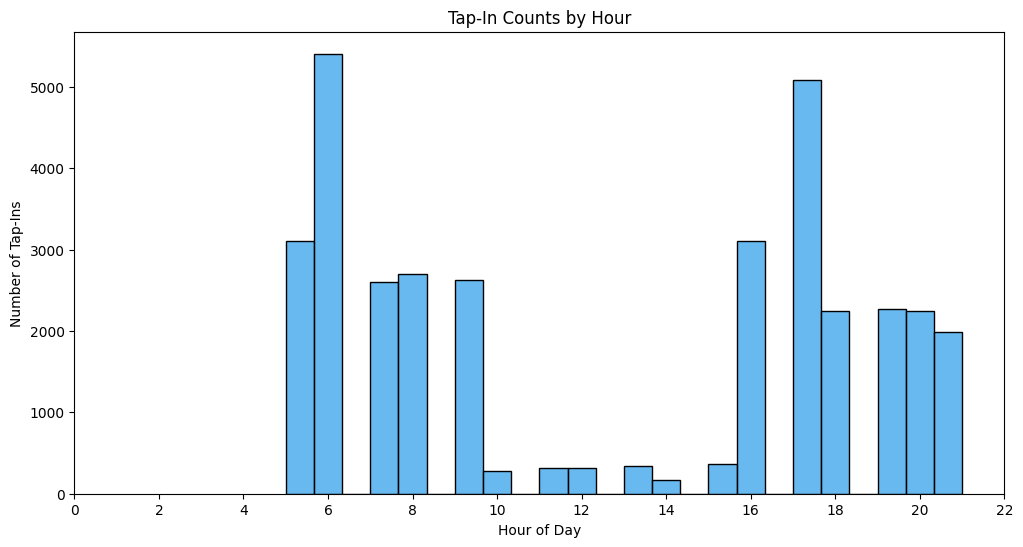

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='tapInHour', bins=24, color='#36A2EB')
plt.title('Tap-In Counts by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Tap-Ins')
plt.xticks(ticks=range(0, 24, 2))
plt.show()

## Top Koridor

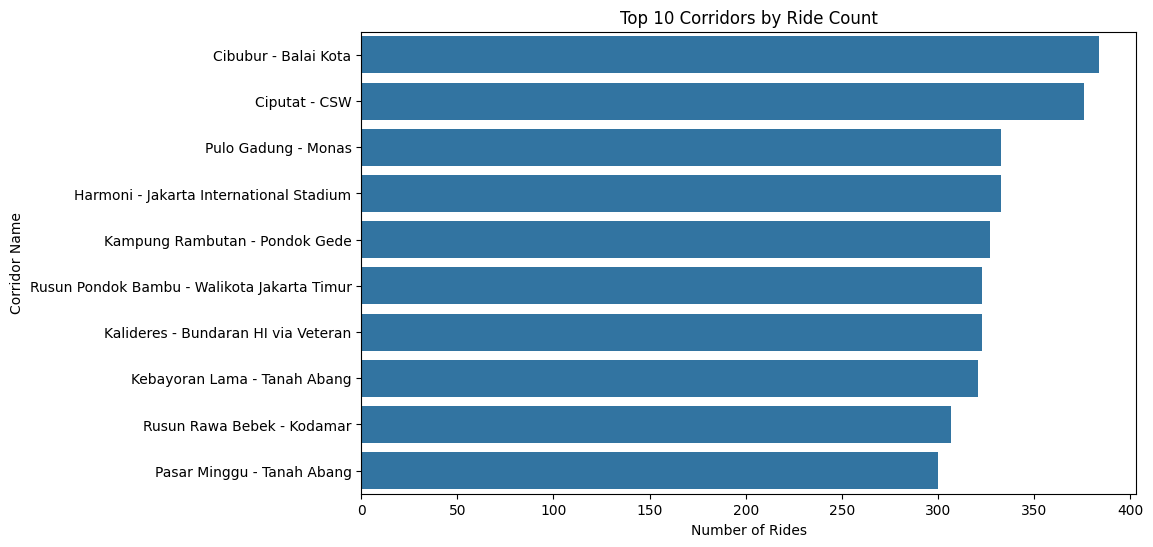

In [30]:
top_corridors = df['corridorName'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corridors.values, y=top_corridors.index)
plt.title('Top 10 Corridors by Ride Count')
plt.xlabel('Number of Rides')
plt.ylabel('Corridor Name')
plt.show()

In [31]:
summary = df[df['is_complete_trip']].groupby('corridorName').agg({
    'transID': 'count',
    'payAmount': 'mean',
    'duration_minutes': 'mean'
}).sort_values('transID', ascending=False).head(5)
print(summary)

                                         transID  payAmount  duration_minutes
corridorName                                                                 
Cibubur - Balai Kota                         384    20000.0         72.214453
Ciputat - CSW                                376     3500.0         76.091090
Harmoni - Jakarta International Stadium      333     3500.0         71.931281
Pulo Gadung - Monas                          333     3500.0         71.594645
Kampung Rambutan - Pondok Gede               327        0.0         71.904434


## Distribusi tarif

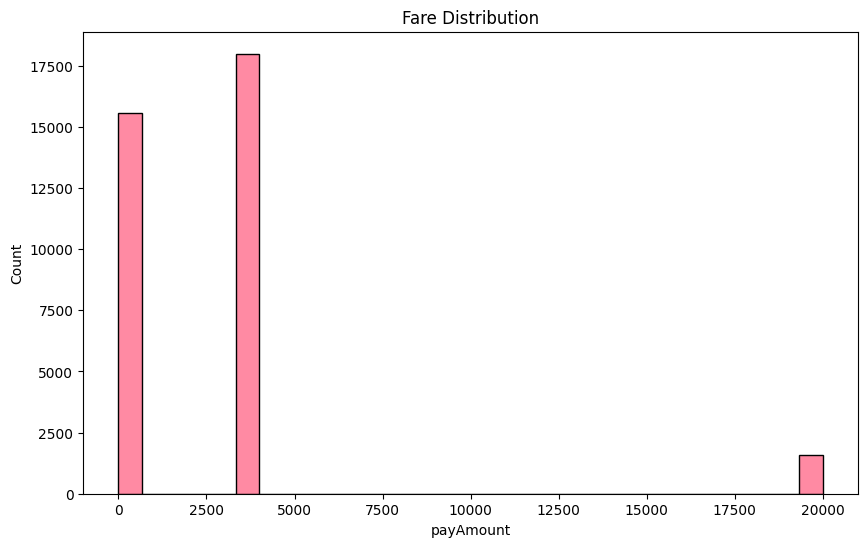

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='payAmount', bins=30, color='#FF6384')
plt.title('Fare Distribution')
plt.show()

## Heatmap korelasi

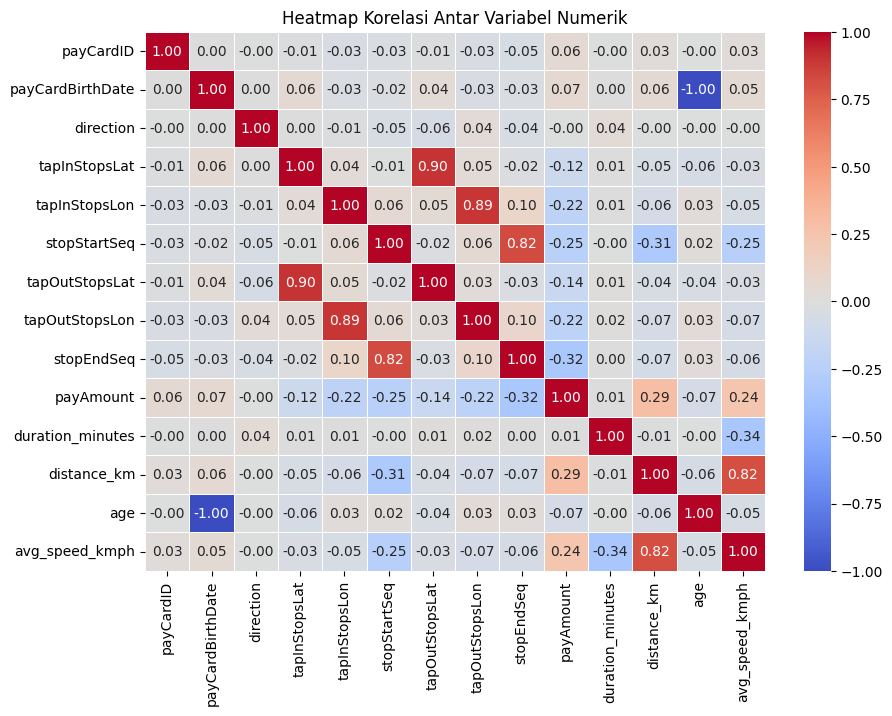

In [33]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
corr = df[num_cols].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=0.5, fmt=".2f")
plt.title("Heatmap Korelasi Antar Variabel Numerik")
plt.show()

## General Map Analysis

In [34]:
stop_counts = df.groupby(['tapInStopsName', 'tapInStopsLat', 'tapInStopsLon']).size().reset_index(name='tap_in_count')

m = folium.Map(location=[-6.2, 106.8], zoom_start=12)

for _, row in stop_counts.iterrows():
    folium.CircleMarker(
        location=[row['tapInStopsLat'], row['tapInStopsLon']],
        radius=min(row['tap_in_count'] / 100, 20),
        popup=f"{row['tapInStopsName']}: {row['tap_in_count']} tap-ins",
        fill=True,
        fill_color='blue',
        color='blue',
        fill_opacity=0.6
    ).add_to(m)

# Save the map
# m.save('jakarta_tapin_map.html')

display(m)

## Boxplot kategori vs durasi

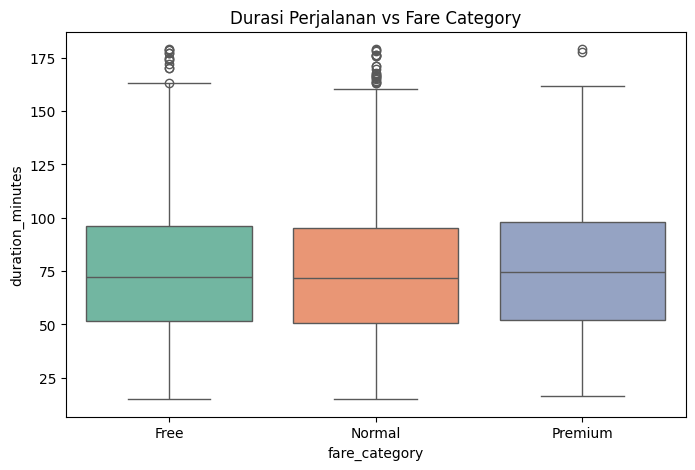

In [36]:
plt.figure(figsize=(8,5))
sns.boxplot(x='fare_category', y='duration_minutes', data=df, hue='fare_category', palette="Set2", legend=False)
plt.title("Durasi Perjalanan vs Fare Category")
plt.show()

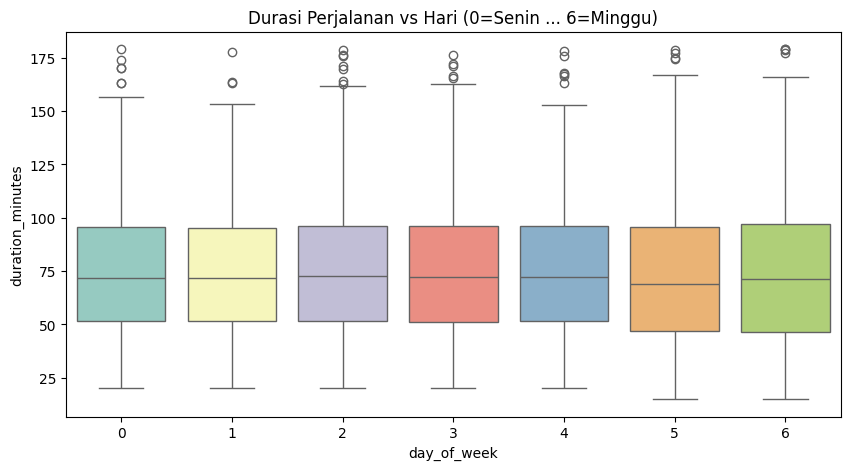

In [38]:
plt.figure(figsize=(10,5))
sns.boxplot(x='day_of_week', y='duration_minutes', data=df,hue='day_of_week',palette="Set3",legend=False)
plt.title("Durasi Perjalanan vs Hari (0=Senin ... 6=Minggu)")
plt.show()

## Kecepatan rata-rata

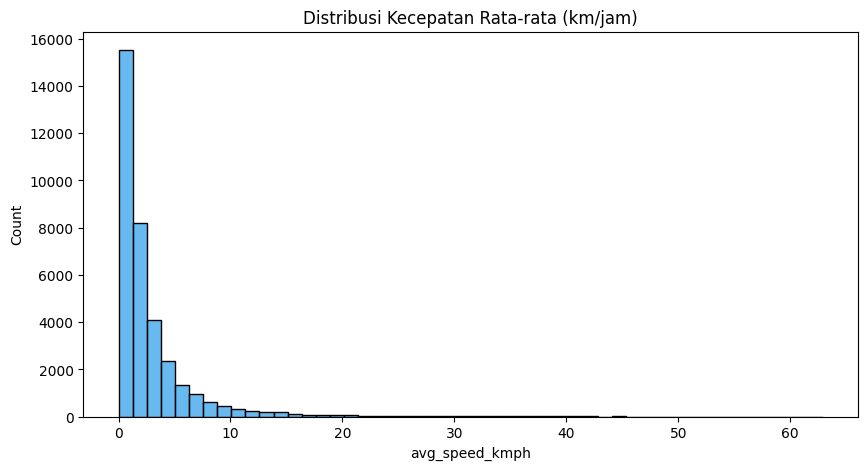

In [39]:
plt.figure(figsize=(10,5))
sns.histplot(df['avg_speed_kmph'], bins=50, color="#36A2EB")
plt.title("Distribusi Kecepatan Rata-rata (km/jam)")
plt.show()

## Outlier check

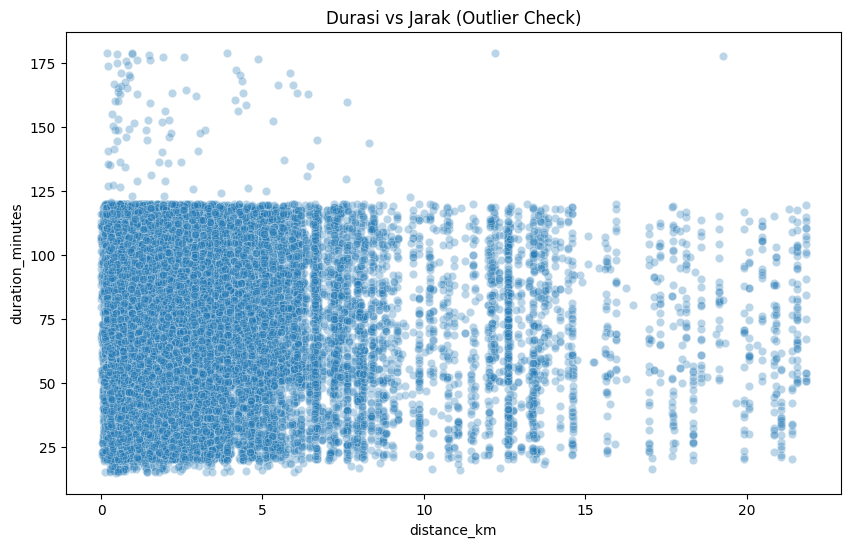

In [40]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='distance_km', y='duration_minutes', data=df, alpha=0.3)
plt.title("Durasi vs Jarak (Outlier Check)")
plt.show()

In [41]:
outliers = df[(df['distance_km'] < 2) & (df['duration_minutes'] > 60)]
print("Jumlah outlier (jarak <2 km & durasi >60 menit):", outliers.shape[0])

Jumlah outlier (jarak <2 km & durasi >60 menit): 12365


## Rata-rata durasi per kategori waktu

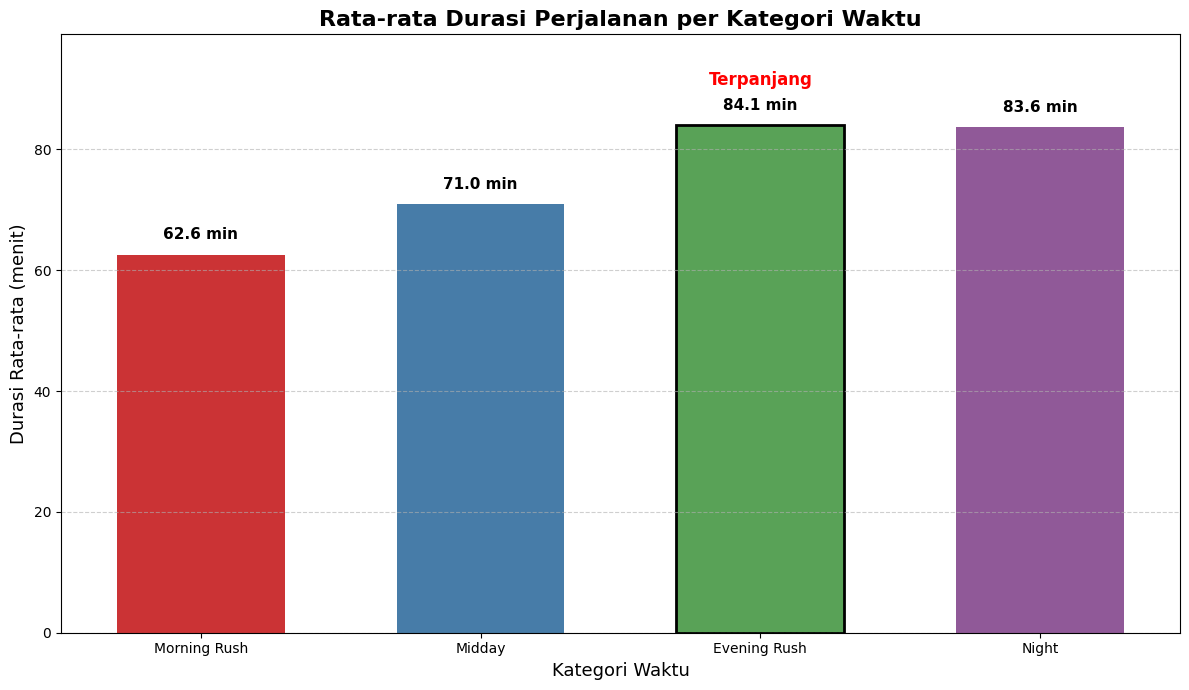

In [48]:
avg_timecat = df.groupby('time_category')['duration_minutes'].mean().reindex(
    ["Morning Rush","Midday","Evening Rush","Night"]
).reset_index()

plt.figure(figsize=(12,7))
ax = sns.barplot(
    x="time_category",
    y="duration_minutes",
    data=avg_timecat,
    hue="time_category",
    palette="Set1",
    legend=False,
    width=0.6
)

for i, v in enumerate(avg_timecat["duration_minutes"]):
    ax.text(i, v+2, f"{v:.1f} min", ha='center', va='bottom', fontsize=11, weight='bold')

max_idx = avg_timecat["duration_minutes"].values.argmax()
ax.patches[max_idx].set_edgecolor("black")
ax.patches[max_idx].set_linewidth(2)

ax.text(max_idx, avg_timecat["duration_minutes"].iloc[max_idx]+6,
        "Terpanjang", ha='center', va='bottom', fontsize=12, color="red", weight='bold')

plt.title("Rata-rata Durasi Perjalanan per Kategori Waktu", fontsize=16, weight='bold')
plt.xlabel("Kategori Waktu", fontsize=13)
plt.ylabel("Durasi Rata-rata (menit)", fontsize=13)
plt.ylim(0, avg_timecat["duration_minutes"].max() + 15)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Top 10 halte

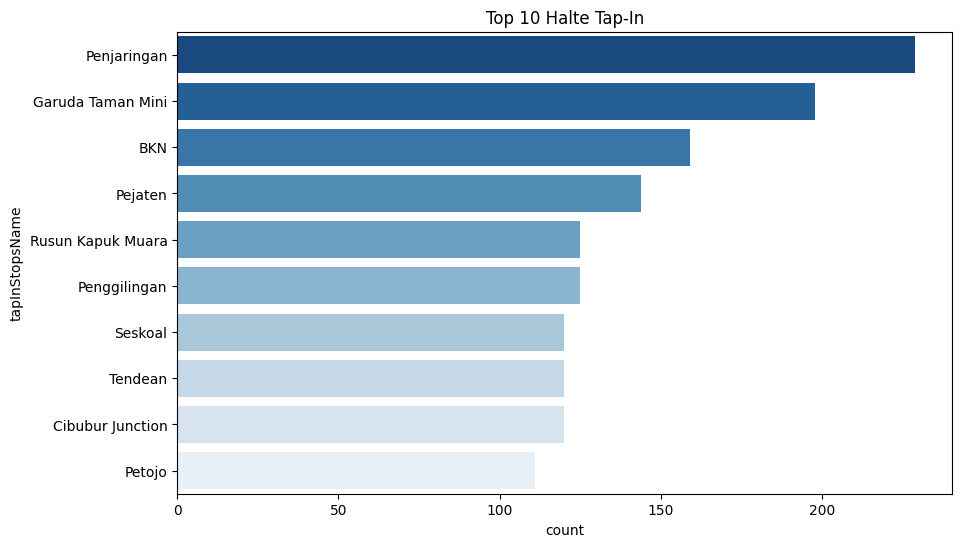

In [50]:
top_tapin = df['tapInStopsName'].value_counts().head(10).reset_index()
top_tapin.columns = ['tapInStopsName', 'count']

plt.figure(figsize=(10,6))
sns.barplot(x="count",y="tapInStopsName", data=top_tapin,hue="tapInStopsName",palette="Blues_r",legend=False)
plt.title("Top 10 Halte Tap-In")
plt.show()

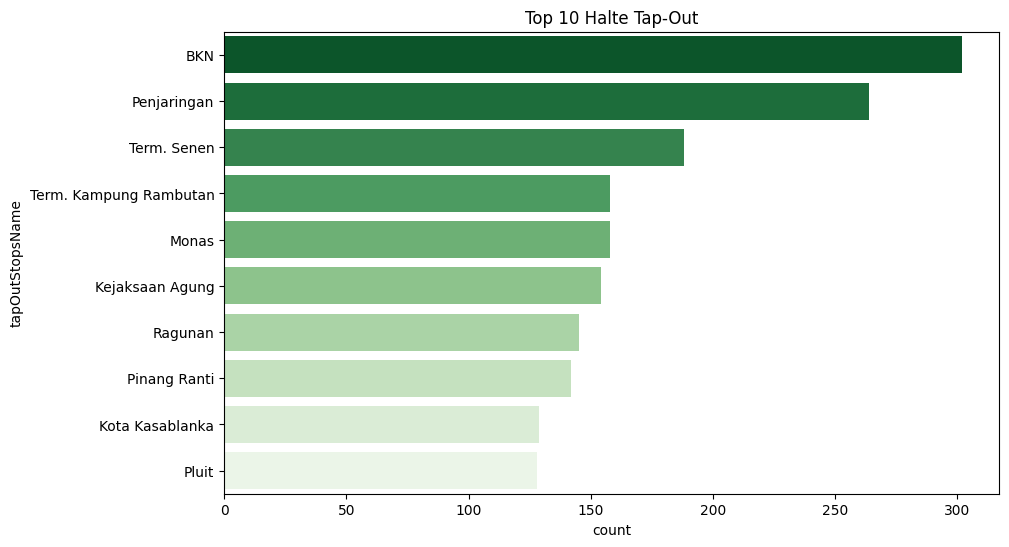

In [51]:
top_tapout = df['tapOutStopsName'].value_counts().head(10).reset_index()
top_tapout.columns = ['tapOutStopsName', 'count']

plt.figure(figsize=(10,6))
sns.barplot(x="count",y="tapOutStopsName",data=top_tapout,hue="tapOutStopsName",palette="Greens_r",legend=False)
plt.title("Top 10 Halte Tap-Out")
plt.show()

## Durasi Rata-rata Perjalanan Weekday vs Weekend

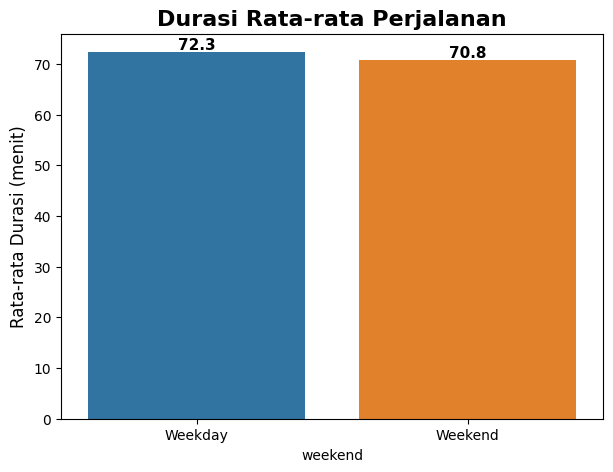

In [63]:
plt.figure(figsize=(7,5))
sns.barplot(x='weekend', y='duration_minutes',hue='weekend' , data=summary)

plt.title("Durasi Rata-rata Perjalanan", fontsize=16, weight='bold')
plt.ylabel("Rata-rata Durasi (menit)", fontsize=12)

for i, v in enumerate(summary['duration_minutes']):
    plt.text(i, v+0.5, f"{v:.1f}", ha='center', fontsize=11, weight='bold')

plt.show()

## Jumlah Perjalanan Weekday vs Weekend

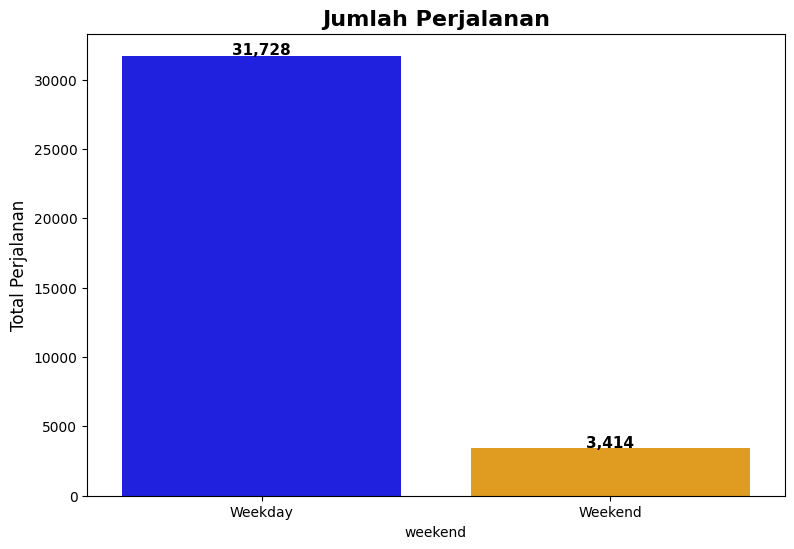

In [69]:
trips = df.assign(weekend=df['day_of_week']>=5) \
          .groupby('weekend')['transID'].count().reset_index()

trips['weekend'] = trips['weekend'].map({False:'Weekday', True:'Weekend'})

plt.figure(figsize=(9,6))
sns.barplot(x='weekend', y='transID', hue='weekend',data=trips, palette={'Weekday':'blue', 'Weekend':'orange'}, legend=False)
plt.title("Jumlah Perjalanan", fontsize=16, weight='bold')
plt.ylabel("Total Perjalanan", fontsize=12)

for i, v in enumerate(trips['transID']):
    plt.text(i, v+100, f"{v:,}", ha='center', fontsize=11, weight='bold')

plt.show()

## Durasi Rata-rata Perjalanan per Jam

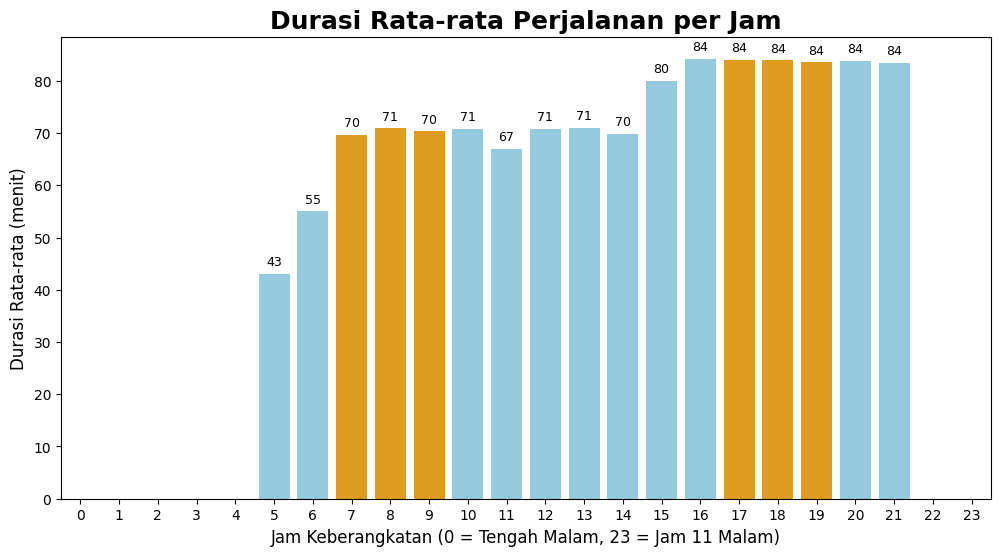

In [73]:
hourly_avg = df.groupby('tapInHour')['duration_minutes'].mean().reindex(range(24), fill_value=0)

plt.figure(figsize=(12,6))
colors = ["orange" if 7 <= h <= 9 or 17 <= h <= 19 else "skyblue" for h in range(24)]

sns.barplot(x=hourly_avg.index,  y=hourly_avg.values, hue=hourly_avg.index,palette=colors, legend=False)

plt.title("Durasi Rata-rata Perjalanan per Jam", fontsize=18, weight='bold')
plt.xlabel("Jam Keberangkatan (0 = Tengah Malam, 23 = Jam 11 Malam)", fontsize=12)
plt.ylabel("Durasi Rata-rata (menit)", fontsize=12)

for i, v in enumerate(hourly_avg.values):
    if v > 0:
        plt.text(i, v+1, f"{v:.0f}", ha='center', va='bottom', fontsize=9)

plt.xticks(range(24))
plt.show()

## Rata-rata Jumlah Penumpang per Hari

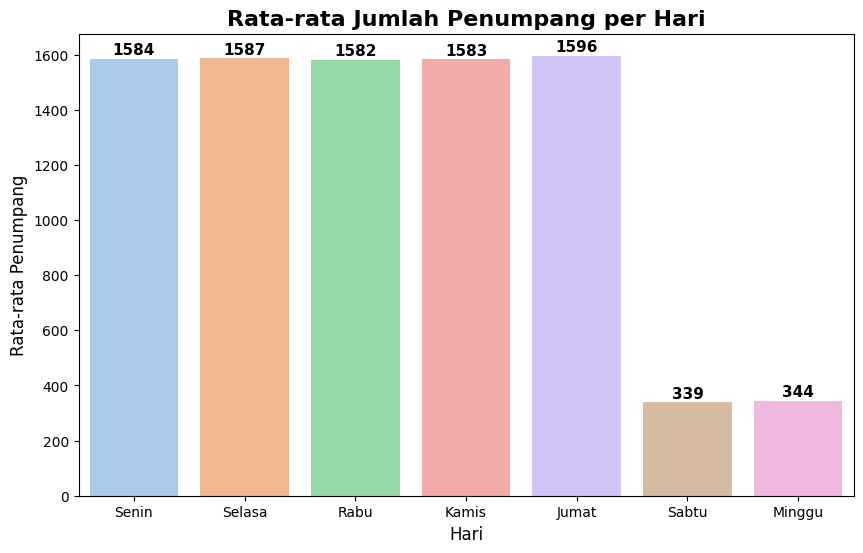

In [72]:
daily_passengers = df.set_index('tapInTime').resample('D')['transID'].count().reset_index()
daily_passengers['day_of_week'] = daily_passengers['tapInTime'].dt.dayofweek

avg_by_day = daily_passengers.groupby('day_of_week')['transID'].mean().reset_index()
avg_by_day['day_name'] = avg_by_day['day_of_week'].map({
    0:'Senin', 1:'Selasa', 2:'Rabu', 3:'Kamis', 4:'Jumat', 5:'Sabtu', 6:'Minggu'
})

plt.figure(figsize=(10,6))
sns.barplot(x='day_name', y='transID',hue='day_name',data=avg_by_day, palette="pastel", legend=False)

plt.title("Rata-rata Jumlah Penumpang per Hari", fontsize=16, weight='bold')
plt.xlabel("Hari", fontsize=12)
plt.ylabel("Rata-rata Penumpang", fontsize=12)

for i, row in avg_by_day.iterrows():
    plt.text(i, row['transID']+5, f"{row['transID']:.0f}",
             ha='center', va='bottom', fontsize=11, weight='bold')

plt.show()

# Model Random Forest Regressor

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import optuna
from sklearn.model_selection import cross_val_score

from sklearn.base import clone
import time

from xgboost import XGBRegressor

In [ ]:
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

def time_category(hour):
    return 1 if (7 <= hour <= 9) or (17 <= hour <= 19) else 0

df['time_category'] = df['tapInHour'].apply(time_category)
df['avg_speed_norm'] = (df['avg_speed_kmph'] - df['avg_speed_kmph'].mean()) / df['avg_speed_kmph'].std()

In [ ]:
features = [
    'distance_km', 'tapInHour', 'day_of_week',
    'stopStartSeq', 'stopEndSeq',
    'corridorID', 'fare_category', 'payCardSex',
    'time_category', 'is_weekend', 'avg_speed_norm'
]

X = df[features]
y = df['duration_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = [
    'distance_km', 'tapInHour', 'day_of_week',
    'stopStartSeq', 'stopEndSeq', 'is_weekend', 'avg_speed_norm'
]
cat_features = ['corridorID', 'fare_category', 'payCardSex', 'time_category']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

In [ ]:
def objective(trial):
    rf = RandomForestRegressor(
        n_estimators=trial.suggest_int("n_estimators", 200, 500),
        max_depth=trial.suggest_categorical("max_depth", [10, 15, 20, None]),
        min_samples_split=trial.suggest_categorical("min_samples_split", [2, 5, 10]),
        min_samples_leaf=trial.suggest_categorical("min_samples_leaf", [1, 2, 4]),
        random_state=42,
        n_jobs=-1
    )
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', rf)
    ])
    score = cross_val_score(pipe, X_train, y_train, cv=3,
                            scoring="neg_mean_squared_error", n_jobs=-1)
    return score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

print(study.best_params)

[I 2025-09-26 02:04:52,190] A new study created in memory with name: no-name-80229bbd-133b-4986-8b0e-2617d8571da3
[I 2025-09-26 02:11:06,004] Trial 0 finished with value: -5.1299587729296645 and parameters: {'n_estimators': 215, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: -5.1299587729296645.
[I 2025-09-26 02:17:56,049] Trial 1 finished with value: -40.25189535125601 and parameters: {'n_estimators': 452, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: -5.1299587729296645.
[I 2025-09-26 02:30:51,444] Trial 2 finished with value: -4.267283108398433 and parameters: {'n_estimators': 367, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 2 with value: -4.267283108398433.
[I 2025-09-26 02:35:32,457] Trial 3 finished with value: -7.29246321509557 and parameters: {'n_estimators': 203, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 2 wit

{'n_estimators': 400, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [ ]:
best_rf = RandomForestRegressor(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)

best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_rf)
])

best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['distance_km', 'tapInHour',
                                                   'day_of_week',
                                                   'stopStartSeq', 'stopEndSeq',
                                                   'is_weekend',
                                                   'avg_speed_norm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['corridorID',
                                                   'fare_category',
                                                   'payCardSex',
                                                   'time_category'])])),
                ('model',
                 RandomForestRegressor(n_estimators=400, n_jobs=-1,
                                       random_state=42))])

In [ ]:
cv_rf = clone(best_rf)
cv_rf.set_params(n_estimators=100)

cv_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', cv_rf)
])

start_time = time.time()

cv_rmse = np.mean(
    np.sqrt(
        -cross_val_score(cv_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    )
)

print(f"CV RMSE (training, quick estimate): {round(cv_rmse, 2)}")
print("CV computation time:", round(time.time() - start_time, 2), "seconds")

CV RMSE (training, quick estimate): 2.05
CV computation time: 500.81 seconds


In [ ]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluasi Model")
print("Best Params:", study.best_params)
print("Test RMSE:", round(rmse, 2))
print("Test MAE:", round(mae, 2))
print("Test R²:", round(r2, 3))


Evaluasi Model
Best Params: {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
Test RMSE: 1.85
Test MAE: 0.58
Test R²: 0.996


RMSE = 1.85
* On average, the model’s prediction is about 1.85 minutes off from the actual travel time.

MAE = 0.58

* Very low average absolute error —  predictions are close to actual travel time.

R² = 0.996

* Explains 99.6% of the variance → excellent fit.

Overfitting?

* With a CV RMSE of ~2.05 and Test RMSE = 1.85 → test error is actually slightly lower than the quick CV estimate.

✅ This confirms no overfitting, model generalizes extremely well.

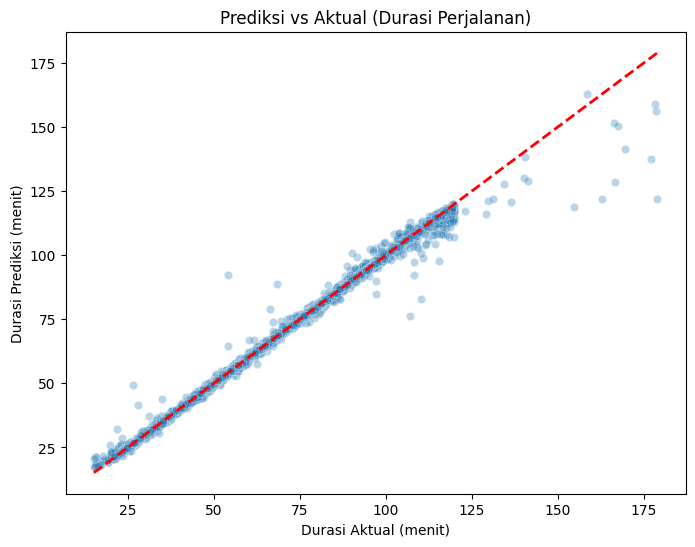

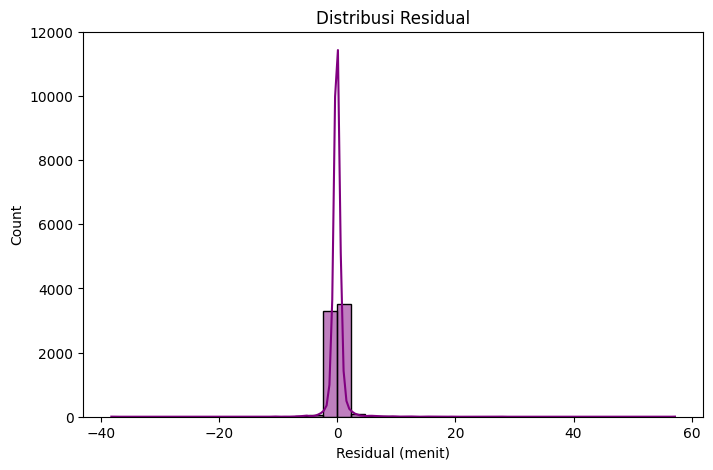

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.title("Prediksi vs Aktual (Durasi Perjalanan)")
plt.xlabel("Durasi Aktual (menit)")
plt.ylabel("Durasi Prediksi (menit)")
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True, color="purple")
plt.title("Distribusi Residual")
plt.xlabel("Residual (menit)")
plt.show()

/tmp/ipython-input-2705284912.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette="viridis")


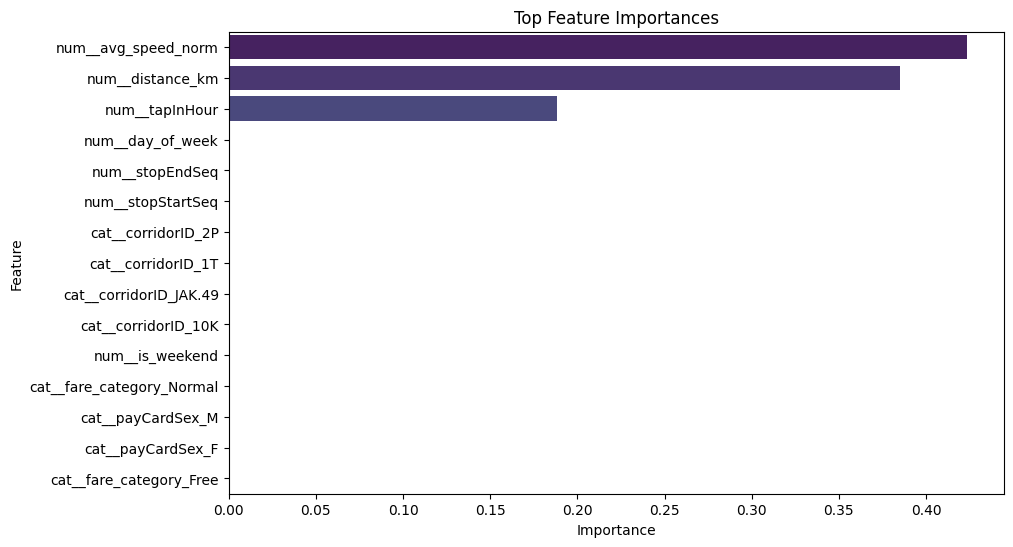

In [ ]:
importances = best_model.named_steps['model'].feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette="viridis")
plt.title("Top Feature Importances")
plt.show()

In [ ]:
def estimate_travel_time(tapInStop, tapOutStop, tapInHour, day_of_week,
                         payCardSex="M", fare_category="Normal"):
    try:
        in_data = df[df['tapInStopsName'] == tapInStop].iloc[0]
        out_data = df[df['tapOutStopsName'] == tapOutStop].iloc[0]
    except IndexError:
        return "⚠️ Halte tidak ditemukan di dataset."

    # Hitung jarak
    dist = haversine(in_data['tapInStopsLat'], in_data['tapInStopsLon'],out_data['tapOutStopsLat'], out_data['tapOutStopsLon'])

    # Tentukan kategori
    time_cat = time_category(tapInHour)
    is_weekend = 1 if day_of_week >= 5 else 0

    # Buat input data dengan avg_speed global
    input_data = pd.DataFrame([{
        'distance_km': dist,
        'tapInHour': tapInHour,
        'day_of_week': day_of_week,
        'stopStartSeq': in_data['stopStartSeq'],
        'stopEndSeq': out_data['stopEndSeq'],
        'corridorID': in_data['corridorID'],
        'payCardSex': payCardSex,
        'fare_category': fare_category,
        'time_category': time_cat,
        'is_weekend': is_weekend,
        'avg_speed_norm': 0  # default rata-rata (sudah dinormalisasi)
    }])

    pred = best_model.predict(input_data)[0]
    lower = max(0, pred - mae)
    upper = pred + mae

    return f"""🚌 Estimasi waktu tempuh dari {tapInStop} ke {tapOutStop} ({'Rush Hour' if time_cat==1 else 'Normal'}):
    Prediksi: {pred:.1f} menit
    Interval perkiraan: {lower:.1f} – {upper:.1f} menit"""

In [ ]:
print(estimate_travel_time("Senen", "Kota", tapInHour=18, day_of_week=2))

🚌 Estimasi waktu tempuh dari Senen ke Kota (Rush Hour):
    Prediksi: 116.9 menit
    Interval perkiraan: 116.3 – 117.5 menit


In [ ]:
df['corridorID'].unique()


array(['5', '6C', 'R1A', '11D', '12', '1T', 'B14', '1Q', '5M', 'M7B',
       '9A', '4', 'JAK.46', 'S22', '13', '9E', 'M9', 'JAK.88', 'T11',
       'JAK.16', '6V', '11Q', 'JAK.02', '11', '1C', '3B', 'M1', '7E',
       '1P', '7D', '6H', '14', 'BW9', 'JIS3', '2', 'JAK.15', '6N', 'M11',
       'JAK.112', '9N', 'JAK.43B', 'JAK.42', '7P', 'JAK.36', '13B',
       'JAK.06', 'JAK.14', 'M7', 'T21', '12A', '9D', '1', '3A', '3C',
       'M8', 'JAK.71', 'JAK.77', 'M3', 'JAK.44', 'JAK.48B', '8K',
       'JAK.19', 'M10', '10D', 'JAK.75', 'B11', 'JAK.52', 'JAK.37',
       'JAK.31', '11M', 'JAK.43C', '2F', '8C', 'M2', '12B', '5D',
       'JAK.117', '3H', 'JAK.49', '7A', '7Q', 'JAK.20', '1M', 'JAK.118',
       '5C', 'JAK.27', '6Q', '4E', 'JAK.13', 'JAK.84', '2H', 'JAK.08',
       '8E', 'JAK.23', '6M', 'JAK.07', 'JAK.22', 'JAK.115', 'JAK.21',
       'JAK.26', 'L13E', '12P', 'JAK.64', 'JAK.47', '1F', '12C', '13C',
       'JAK.01', 'JAK.120', '4B', '7C', 'JAK.85', '11N', 'JAK.10', '2E',
       '2A', 'JAK.4

In [ ]:
!pip install openrouteservice

In [ ]:
import networkx as nx
import folium
import openrouteservice

def visualize_bus_route_ors(df, tapInStop, tapOutStop, ors_api_key):
    # Normalisasi nama halte
    tapInStop_norm = tapInStop.strip().lower()
    tapOutStop_norm = tapOutStop.strip().lower()
    df['tapInStopsName_norm'] = df['tapInStopsName'].astype(str).str.strip().str.lower()
    df['tapOutStopsName_norm'] = df['tapOutStopsName'].astype(str).str.strip().str.lower()

    # Build graph dari dataset
    G = nx.DiGraph()
    for _, row in df.iterrows():
        start = row['tapInStopsName_norm']
        end = row['tapOutStopsName_norm']
        G.add_edge(start, end, weight=row['distance_km'],
                   lat=row['tapInStopsLat'], lon=row['tapInStopsLon'])

    # Cek keberadaan halte
    if tapInStop_norm not in G or tapOutStop_norm not in G:
        return f"⚠️ Halte '{tapInStop}' atau '{tapOutStop}' tidak ada di dataset."

    # Cari shortest path antar halte
    try:
        path = nx.shortest_path(G, source=tapInStop_norm, target=tapOutStop_norm, weight='weight')
    except nx.NetworkXNoPath:
        return f"⚠️ Tidak ada rute dari {tapInStop} ke {tapOutStop}."

    # Client ORS
    client = openrouteservice.Client(key=ors_api_key)

    # Buat polyline gabungan
    full_route_coords = []
    for i in range(len(path)-1):
        start_row = df[df['tapInStopsName_norm'] == path[i]].iloc[0]
        end_row = df[df['tapInStopsName_norm'] == path[i+1]].iloc[0]
        start_coord = (start_row['tapInStopsLon'], start_row['tapInStopsLat'])
        end_coord = (end_row['tapInStopsLon'], end_row['tapInStopsLat'])

        # ORS directions
        segment = client.directions(coordinates=[start_coord, end_coord], profile='driving-car', format='geojson')
        segment_coords = [(c[1], c[0]) for c in segment['features'][0]['geometry']['coordinates']]

        # Gabungkan segmen tanpa duplikat
        if i > 0:
            segment_coords = segment_coords[1:]
        full_route_coords.extend(segment_coords)

    # Buat map
    mid_lat = (full_route_coords[0][0] + full_route_coords[-1][0]) / 2
    mid_lon = (full_route_coords[0][1] + full_route_coords[-1][1]) / 2
    m = folium.Map(location=[mid_lat, mid_lon], zoom_start=13)

    # Marker awal & akhir
    folium.Marker(full_route_coords[0], tooltip=tapInStop, icon=folium.Icon(color='green')).add_to(m)
    folium.Marker(full_route_coords[-1], tooltip=tapOutStop, icon=folium.Icon(color='red')).add_to(m)

    # Polyline jalur
    folium.PolyLine(full_route_coords, color="blue", weight=3, opacity=0.7).add_to(m)

    return m

In [ ]:
m = visualize_route_with_ors(
    tapInStop="Senen",
    tapOutStop="Kota",
    df=df,
    ors_api_key="eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6ImNmYzgyYTNhZTVkMjRiYzE5NjA5OTBjMTQ0ZWQ2ZjE5IiwiaCI6Im11cm11cjY0In0="
)

m

In [ ]:
import networkx as nx
import folium
import openrouteservice

def visualize_bus_route_ors(df, tapInStop, tapOutStop, ors_api_key, show_console=True):
    # Normalisasi nama halte
    tapInStop_norm = tapInStop.strip().lower()
    tapOutStop_norm = tapOutStop.strip().lower()
    df['tapInStopsName_norm'] = df['tapInStopsName'].astype(str).str.strip().str.lower()
    df['tapOutStopsName_norm'] = df['tapOutStopsName'].astype(str).str.strip().str.lower()

    # Build graph dari dataset
    G = nx.DiGraph()
    for _, row in df.iterrows():
        start = row['tapInStopsName_norm']
        end = row['tapOutStopsName_norm']
        G.add_edge(start, end, weight=row['distance_km'],
                   lat=row['tapInStopsLat'], lon=row['tapInStopsLon'])

    # Cek keberadaan halte
    if tapInStop_norm not in G or tapOutStop_norm not in G:
        return f"⚠️ Halte '{tapInStop}' atau '{tapOutStop}' tidak ada di dataset."

    # Cari shortest path antar halte
    try:
        path = nx.shortest_path(G, source=tapInStop_norm, target=tapOutStop_norm, weight='weight')
    except nx.NetworkXNoPath:
        return f"⚠️ Tidak ada rute dari {tapInStop} ke {tapOutStop}."

    # Print halte yang dilewati (opsional)
    if show_console:
        print("🚌 Halte yang dilewati:")
        for i, halte in enumerate(path, 1):
            original_name = df[df['tapInStopsName_norm'] == halte].iloc[0]['tapInStopsName']
            print(f"{i}. {original_name}")

    # Client ORS
    client = openrouteservice.Client(key=ors_api_key)

    # Buat polyline gabungan
    full_route_coords = []
    halte_coords = []
    halte_labels = []
    for i in range(len(path)-1):
        start_row = df[df['tapInStopsName_norm'] == path[i]].iloc[0]
        end_row = df[df['tapInStopsName_norm'] == path[i+1]].iloc[0]

        start_coord = (start_row['tapInStopsLon'], start_row['tapInStopsLat'])
        end_coord = (end_row['tapInStopsLon'], end_row['tapInStopsLat'])

        halte_coords.append((start_row['tapInStopsLat'], start_row['tapInStopsLon']))
        halte_labels.append(start_row['tapInStopsName'])

        # ORS directions
        segment = client.directions(
            coordinates=[start_coord, end_coord],
            profile='driving-car',
            format='geojson'
        )
        segment_coords = [(c[1], c[0]) for c in segment['features'][0]['geometry']['coordinates']]

        if i > 0:
            segment_coords = segment_coords[1:]
        full_route_coords.extend(segment_coords)

    # Tambahkan halte akhir juga
    end_row = df[df['tapInStopsName_norm'] == path[-1]].iloc[0]
    halte_coords.append((end_row['tapInStopsLat'], end_row['tapInStopsLon']))
    halte_labels.append(end_row['tapInStopsName'])

    # Buat map
    mid_lat = (full_route_coords[0][0] + full_route_coords[-1][0]) / 2
    mid_lon = (full_route_coords[0][1] + full_route_coords[-1][1]) / 2
    m = folium.Map(location=[mid_lat, mid_lon], zoom_start=13)

    # Marker halte
    for i, (coord, label) in enumerate(zip(halte_coords, halte_labels)):
        if i == 0:
            color = "green"
        elif i == len(halte_coords)-1:
            color = "red"
        else:
            color = "blue"
        folium.Marker(coord, tooltip=label,
                      icon=folium.Icon(color=color, icon="info-sign")).add_to(m)

    # Polyline jalur
    folium.PolyLine(full_route_coords, color="blue", weight=4, opacity=0.8).add_to(m)

    return m


In [ ]:
m = visualize_bus_route_ors(
    tapInStop="Senen",
    tapOutStop="Kota",
    df=df,
    ors_api_key="eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6ImNmYzgyYTNhZTVkMjRiYzE5NjA5OTBjMTQ0ZWQ2ZjE5IiwiaCI6Im11cm11cjY0In0="
)

m

🚌 Halte yang dilewati:
1. Senen
2. Kwitang
3. Balai Kota
4. Pecenongan
5. Harmoni Arah Utara
6. Glodok
7. Kota


# XGBRegressor

In [ ]:
def objective_xgb(trial):
    xgb = XGBRegressor(
        n_estimators=trial.suggest_int("n_estimators", 200, 500),
        max_depth=trial.suggest_int("max_depth", 3, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        random_state=42,
        n_jobs=-1,
        tree_method="hist"  # cepat
    )
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb)
    ])
    score = cross_val_score(pipe, X_train, y_train, cv=3,
                            scoring="neg_mean_squared_error", n_jobs=-1)
    return score.mean()

In [ ]:
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=15)

print("Best Params (XGB):", study_xgb.best_params)

[I 2025-09-26 14:07:39,630] A new study created in memory with name: no-name-35c071bb-22a3-4455-9fe9-ec0f4fed02e5
[I 2025-09-26 14:07:48,112] Trial 0 finished with value: -7.070451921251017 and parameters: {'n_estimators': 421, 'max_depth': 6, 'learning_rate': 0.11672153652615401, 'subsample': 0.794958554573412, 'colsample_bytree': 0.8749643006365138, 'min_child_weight': 2}. Best is trial 0 with value: -7.070451921251017.
[I 2025-09-26 14:07:52,187] Trial 1 finished with value: -9.553728964021428 and parameters: {'n_estimators': 490, 'max_depth': 5, 'learning_rate': 0.2680650698907697, 'subsample': 0.9162366813263236, 'colsample_bytree': 0.6274065778294807, 'min_child_weight': 1}. Best is trial 0 with value: -7.070451921251017.
[I 2025-09-26 14:07:54,060] Trial 2 finished with value: -8.770371940309802 and parameters: {'n_estimators': 205, 'max_depth': 6, 'learning_rate': 0.2248965429862659, 'subsample': 0.9482863789322202, 'colsample_bytree': 0.9035707645994167, 'min_child_weight': 9}

Best Params (XGB): {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.0304436056526964, 'subsample': 0.6159755002471018, 'colsample_bytree': 0.9839213757261779, 'min_child_weight': 6}


In [ ]:
best_xgb = XGBRegressor(
    **study_xgb.best_params,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

best_model_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_xgb)
])

best_model_xgb.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['distance_km', 'tapInHour',
                                                   'day_of_week',
                                                   'stopStartSeq', 'stopEndSeq',
                                                   'is_weekend',
                                                   'avg_speed_norm']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['corridorID',
                                                   'fare_category',
                                                   'payCardSex',
                                                   'time_category'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None,...
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.0304436056526964, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=6, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=437, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [ ]:
y_pred_xgb = best_model_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nEvaluasi Model XGBoost")
print("Best Params:", study_xgb.best_params)
print("Test RMSE:", round(rmse_xgb, 2))
print("Test MAE:", round(mae_xgb, 2))
print("Test R²:", round(r2_xgb, 3))


Evaluasi Model XGBoost
Best Params: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.0304436056526964, 'subsample': 0.6159755002471018, 'colsample_bytree': 0.9839213757261779, 'min_child_weight': 6}
Test RMSE: 2.1
Test MAE: 0.91
Test R²: 0.994


In [ ]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'RMSE': [rmse, rmse_xgb],
    'MAE': [mae, mae_xgb],
    'R2': [r2, r2_xgb]
})

plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='RMSE', data=results, palette="Set2")
plt.title("Perbandingan RMSE Random Forest vs XGBoost")
plt.ylabel("RMSE (lebih rendah lebih baik)")
plt.show()

display(results)

NameError: name 'rmse' is not defined